In [1]:
import lightgbm as lgb

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rc("font", size=14)
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
#from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

from azureml.core import Experiment
from azureml.core import Workspace, Dataset


In [3]:
import shap
shap.initjs()

In [4]:
subscription_id = '6ed9d167-b2e6-41b8-9500-35e6df64d9dc'
resource_group = 'MLRG'
workspace_name = 'erbbimlws'

workspace = Workspace(subscription_id, resource_group, workspace_name)

In [5]:
experiment = Experiment(workspace = workspace, name = "LightGBM_on_Primary_Bank")

In [6]:
run = experiment.start_logging(snapshot_directory=None)

In [7]:
dataset = Dataset.get_by_name(workspace, name='Primary_Bank')
df = dataset.to_pandas_dataframe()

In [8]:
pd.set_option('max_columns', None) #display all columns
#pd.reset_option(“max_columns”) #to return to default

In [9]:
df.head()

,Customer_ID,Year,Month,Legal_Person,Gender,Active_Customer,Segment,SubSegment,SubSubSegment,Priority_Segment,SB_Customer,Total_Funds_Balances_Avg_1M,Total_Deposits_Balances_Avg_1M,Total_Loans_Balances_OutStanding_1M,Total_Deposits_All_Beneficieries_Balances_Avg_1M,Total_Funds_All_Beneficieries_Balances_Avg_1M,Bucket_Max_1M,Bucket_Max_1Y,Bucket_Months_Count_1Y,Days_Since_Last_Transaction,Education,Occupation,Marital_Status,Age_Band,Age,POS_Balance_Sum_1Y,Checks_Issued_Last_1Y_Num,Checks_Issued_Last_1Y_Amount,Checks_Issued_MaxAmount_1Y,Checks_Issued_DaysSince_1Y,Remmitances_Out_GR_Num_Sum_1Y,Remmitances_Out_GR_Amount_Sum_1Y,Remmitances_Out_GR_Amount_Max_1Y,Remmitances_Out_GR_DaysSince_1Y,Remmitances_Out_nonGR_Num_Sum_1Y,Remmitances_Out_nonGR_Amount_Sum_1Y,Remmitances_Out_nonGR_Amount_Max_1Y,Remmitances_Out_nonGR_DaysSince_1Y,Remmitances_In_GR_Num_Sum_1Y,Remmitances_In_GR_Amount_Sum_1Y,Remmitances_In_GR_1Y_Amount_Max_1Y,Remmitances_In_GR_DaysSince_1Y,Remmitances_In_nonGR_Num_Sum_1Y,Remmitances_In_nonGR_Amount_Sum_1Y,Remmitances_In_nonGR_Amount_Max_1Y,Remmitances_In_nonGR_DaysSince_1Y,Latest_Product_Opening,Rescheduling_Flag,Epistofi_Purchases_Num_Sum_6M,Epistofi_Points_Amount_Sum_6M,Epistofi_Redeemed_Amount_Sum_6M,Epistofi_Redeemed_Amount_Max_6M,Epistofi_Redemptions_Num_Sum_6M,SafeBox_active,Safebox_Last_Opening_date,CC_BasicNeeds_Purchases_Num_Sum_6M,CC_BasicNeeds_Purchases_Amount_Sum_6M,CC_BasicNeeds_Purchases_Amount_Max_6M,CC_HouseNeeds_Purchases_Num_Sum_6M,CC_HouseNeeds_Purchases_Amount_Sum_6M,CC_HouseNeeds_Purchases_Amount_Max_6M,CC_PersonalNeeds_Purchases_Num_Sum_6M,CC_PersonalNeeds_Purchases_Amount_Sum_6M,CC_PersonalNeeds_Purchases_Amount_Max_6M,DC_BasicNeeds_Purchases_Num_Sum_6M,DC_BasicNeeds_Purchases_Amount_Sum_6M,DC_BasicNeeds_Purchases_Amount_Max_6M,DC_HouseNeeds_Purchases_Num_Sum_6M,DC_HouseNeeds_Purchases_Amount_Sum_6M,DC_HouseNeeds_Purchases_Amount_Max_6M,DC_PersonalNeeds_Purchases_Num_Sum_6m,DC_PersonalNeeds_Purchases_Amount_Sum_6M,DC_PersonalNeeds_Purchases_Amount_Max_6M,Total_Funds_Balance_Min_Ever,Total_Funds_Balance_Max_Ever,Total_Trans_Num_Sum_6M,Total_Trans_Amount_Sum_6M,Total_Trans_Days_Count_6M,Total_Trans_Date_Last_6M,Credit_Trans_Num_Sum_6M,Credit_Trans_Amount_Sum_6M,Credit_Trans_Days_Count_6M,Debit_Trans_Num_Sum_6M,Debit_Trans_Amount_Sum_6M,Debit_Trans_Days_Count_6M,Branch_Trans_Num_Sum_6M,Branch_Trans_Amount_Sum_6M,Branch_Trans_Days_Count_6M,ATM_Trans_Num_Sum_6M,ATM_Trans_Amount_Sum_6M,ATM_Trans_Days_Count_6M,Phone_Trans_Num_Sum_6M,Phone_Trans_Amount_Sum_6M,Phone_Trans_Days_Count_6M,EB_Trans_Num_Sum_6M,EB_Trans_Amount_Sum_6M,EB_Trans_Days_Count_6M,APS_Trans_Num_Sum_6M,APS_Trans_Amount_Sum_6M,APS_Trans_Days_Count_6M,LivePay_Trans_Num_Sum_6M,LivePay_Trans_Amount_Sum_6M,LivePay_Trans_Days_Count_6M,Payments_Trans_Num_Sum_6M,Payments_Trans_Amount_Sum_6M,Payments_Trans_Days_Count_6M,Remittance_Trans_Num_Sum_6M,Remittance_Trans_Amount_Sum_6M,Remittance_Trans_Days_Count_6M,CC_Total_Purchases_Num_Sum_6M,CC_Total_Purchases_Amount_Sum_6M,CC_Total_Purchases_Amount_Max_6M,CC_Total_Purchases_Date_Last_6M,DC_Total_Purchases_Num_Sum_6M,DC_Total_Purchases_Amount_Sum_6M,DC_Total_Purchases_Amount_Max_6M,DC_Total_Purchases_Date_Last_6M,Group_Sales_Group_Code,Group_Sales_Payments_Num_Sum_6M,Group_Sales_Payment_Months_Distinct_6M,Group_Sales_Salary_Avg_6M,Group_Sales_Active_Flag,Trn_Deposit_Num_Sum_6M,Trn_Deposit_Amount_Sum_6M,Trn_Deposit_Days_Count_6M,Trn_Withdrawal_Num_Sum_6M,Trn_Withdrawal_Amount_Sum_6M,Trn_Withdrawal_Days_Count_6M,Trn_InternalTransfer_Num_Sum_6M,Trn_InternalTransfer_Amount_Sum_6M,Trn_InternalTransfer_Days_Count_6M,Trn_EurobankCheckDeposit_Num_Sum_6M,Trn_EurobankCheckDeposit_Amount_Sum_6M,Trn_EurobankCheckDeposit_Days_Count_6M,Trn_Checkpayment_Num_Sum_6M,Trn_Checkpayment_Amount_Sum_6M,Trn_Checkpayment_Days_Count_6M,Trn_OtherbankCheckDeposit_Num_Sum_6M,Trn_OtherbankCheckDeposit_Amount_Sum_6M,Trn_OtherbankCheckDeposit_Days_Count_6M,Trn_ChecksOther_Num_Sum_6M,Trn_ChecksOther_Amount_Sum_6M,Trn_ChecksOther_D

<AxesSubplot:title={'center':'New_Primary_Bank_Flag'}, ylabel='New_Primary_Bank_Flag'>

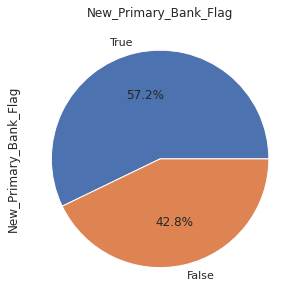

In [10]:
df['New_Primary_Bank_Flag'].value_counts().plot(kind = 'pie',y = 'New_Primary_Bank_Flag',figsize=(5, 5),title = 'New_Primary_Bank_Flag',autopct='%1.1f%%')


In [11]:
df = df.drop(columns = ['Customer_ID','Year','Month','Primary_Bank'])

In [12]:
def binF(x):
    if x is False:
        z = 0
    elif math.isnan(x):
        z = 0
    else:
        z =1
    return z

In [13]:
df['New_Primary_Bank_Flag'] = df['New_Primary_Bank_Flag'].apply(binF)

In [14]:
#dummy variables
for col in df.columns:       
       if df[col].dtypes=='object':
            df.drop(columns=col, inplace = True)
            #df = pd.get_dummies(df, prefix=col + '_', columns=[col])
    

In [15]:
for col in df.columns:       
       if df[col].dtypes=='datetime64[ns]':
            df = df.drop(columns = col)


In [16]:
def replace_gt(x):
    x = x.replace('<=','le ')
    x = x.replace('>=','ge')
    x = x.replace('>','gt ')
    x = x.replace('<','lt ')
    return x

In [17]:
df.columns = [replace_gt(x) for x in df.columns]

In [18]:
df.head()

,Active_Customer,SB_Customer,Total_Funds_Balances_Avg_1M,Total_Deposits_Balances_Avg_1M,Total_Loans_Balances_OutStanding_1M,Total_Deposits_All_Beneficieries_Balances_Avg_1M,Total_Funds_All_Beneficieries_Balances_Avg_1M,Bucket_Max_1M,Bucket_Max_1Y,Bucket_Months_Count_1Y,Days_Since_Last_Transaction,Age,POS_Balance_Sum_1Y,Checks_Issued_Last_1Y_Num,Checks_Issued_Last_1Y_Amount,Checks_Issued_MaxAmount_1Y,Checks_Issued_DaysSince_1Y,Remmitances_Out_GR_Num_Sum_1Y,Remmitances_Out_GR_Amount_Sum_1Y,Remmitances_Out_GR_Amount_Max_1Y,Remmitances_Out_GR_DaysSince_1Y,Remmitances_Out_nonGR_Num_Sum_1Y,Remmitances_Out_nonGR_Amount_Sum_1Y,Remmitances_Out_nonGR_Amount_Max_1Y,Remmitances_Out_nonGR_DaysSince_1Y,Remmitances_In_GR_Num_Sum_1Y,Remmitances_In_GR_Amount_Sum_1Y,Remmitances_In_GR_1Y_Amount_Max_1Y,Remmitances_In_GR_DaysSince_1Y,Remmitances_In_nonGR_Num_Sum_1Y,Remmitances_In_nonGR_Amount_Sum_1Y,Remmitances_In_nonGR_Amount_Max_1Y,Remmitances_In_nonGR_DaysSince_1Y,Rescheduling_Flag,Epistofi_Purchases_Num_Sum_6M,Epistofi_Points_Amount_Sum_6M,Epistofi_Redeemed_Amount_Sum_6M,Epistofi_Redeemed_Amount_Max_6M,Epistofi_Redemptions_Num_Sum_6M,SafeBox_active,CC_BasicNeeds_Purchases_Num_Sum_6M,CC_BasicNeeds_Purchases_Amount_Sum_6M,CC_BasicNeeds_Purchases_Amount_Max_6M,CC_HouseNeeds_Purchases_Num_Sum_6M,CC_HouseNeeds_Purchases_Amount_Sum_6M,CC_HouseNeeds_Purchases_Amount_Max_6M,CC_PersonalNeeds_Purchases_Num_Sum_6M,CC_PersonalNeeds_Purchases_Amount_Sum_6M,CC_PersonalNeeds_Purchases_Amount_Max_6M,DC_BasicNeeds_Purchases_Num_Sum_6M,DC_BasicNeeds_Purchases_Amount_Sum_6M,DC_BasicNeeds_Purchases_Amount_Max_6M,DC_HouseNeeds_Purchases_Num_Sum_6M,DC_HouseNeeds_Purchases_Amount_Sum_6M,DC_HouseNeeds_Purchases_Amount_Max_6M,DC_PersonalNeeds_Purchases_Num_Sum_6m,DC_PersonalNeeds_Purchases_Amount_Sum_6M,DC_PersonalNeeds_Purchases_Amount_Max_6M,Total_Funds_Balance_Min_Ever,Total_Funds_Balance_Max_Ever,Total_Trans_Num_Sum_6M,Total_Trans_Amount_Sum_6M,Total_Trans_Days_Count_6M,Credit_Trans_Num_Sum_6M,Credit_Trans_Amount_Sum_6M,Credit_Trans_Days_Count_6M,Debit_Trans_Num_Sum_6M,Debit_Trans_Amount_Sum_6M,Debit_Trans_Days_Count_6M,Branch_Trans_Num_Sum_6M,Branch_Trans_Amount_Sum_6M,Branch_Trans_Days_Count_6M,ATM_Trans_Num_Sum_6M,ATM_Trans_Amount_Sum_6M,ATM_Trans_Days_Count_6M,Phone_Trans_Num_Sum_6M,Phone_Trans_Amount_Sum_6M,Phone_Trans_Days_Count_6M,EB_Trans_Num_Sum_6M,EB_Trans_Amount_Sum_6M,EB_Trans_Days_Count_6M,APS_Trans_Num_Sum_6M,APS_Trans_Amount_Sum_6M,APS_Trans_Days_Count_6M,LivePay_Trans_Num_Sum_6M,LivePay_Trans_Amount_Sum_6M,LivePay_Trans_Days_Count_6M,Payments_Trans_Num_Sum_6M,Payments_Trans_Amount_Sum_6M,Payments_Trans_Days_Count_6M,Remittance_Trans_Num_Sum_6M,Remittance_Trans_Amount_Sum_6M,Remittance_Trans_Days_Count_6M,CC_Total_Purchases_Num_Sum_6M,CC_Total_Purchases_Amount_Sum_6M,CC_Total_Purchases_Amount_Max_6M,DC_Total_Purchases_Num_Sum_6M,DC_Total_Purchases_Amount_Sum_6M,DC_Total_Purchases_Amount_Max_6M,Group_Sales_Payments_Num_Sum_6M,Group_Sales_Payment_Months_Distinct_6M,Group_Sales_Salary_Avg_6M,Group_Sales_Active_Flag,Trn_Deposit_Num_Sum_6M,Trn_Deposit_Amount_Sum_6M,Trn_Deposit_Days_Count_6M,Trn_Withdrawal_Num_Sum_6M,Trn_Withdrawal_Amount_Sum_6M,Trn_Withdrawal_Days_Count_6M,Trn_InternalTransfer_Num_Sum_6M,Trn_InternalTransfer_Amount_Sum_6M,Trn_InternalTransfer_Days_Count_6M,Trn_EurobankCheckDeposit_Num_Sum_6M,Trn_EurobankCheckDeposit_Amount_Sum_6M,Trn_EurobankCheckDeposit_Days_Count_6M,Trn_Checkpayment_Num_Sum_6M,Trn_Checkpayment_Amount_Sum_6M,Trn_Checkpayment_Days_Count_6M,Trn_OtherbankCheckDeposit_Num_Sum_6M,Trn_OtherbankCheckDeposit_Amount_Sum_6M,Trn_OtherbankCheckDeposit_Days_Count_6M,Trn_ChecksOther_Num_Sum_6M,Trn_ChecksOther_Amount_Sum_6M,Trn_ChecksOther_Days_Count_6M,Trn_EurobankCheckIssue_Num_Sum_6M,Trn_EurobankCheckIssue_Amount_Sum_6M,Trn_EurobankCheckIssue_Days_Count_6M,Trn_TimeDeposit_Num_Sum_6M,Trn_TimeDeposit_Amount_Sum_6M,Trn_TimeDeposit_Days_Count_6M,Trn_CashAdvance_Num_Sum_6M,Trn_CashAdvance_Amount_Sum_6M,Trn_CashAdvance_Days_Count_6M,Trn_

In [19]:
x_train, x_test, y_train, y_test = train_test_split(df.loc[:,df.columns !='New_Primary_Bank_Flag'].fillna(0), df['New_Primary_Bank_Flag'].fillna(0), test_size=0.25, random_state=0)
#x_train, x_test, y_train, y_test = train_test_split(df.loc[:,important_features].fillna(0), df['New_Primary_Bank_Flag'].fillna(0), test_size=0.25, random_state=0)


In [20]:
parameters = {'max_depth':5,'colsample_bytree':0.5,'min_data_in_leaf':1000}

In [22]:
run.log_table('Parameters', parameters)

In [23]:
model = lgb.LGBMClassifier(**parameters)

In [24]:
model.fit(x_train,y_train,early_stopping_rounds =10,\
            eval_metric = 'aucpr', eval_set = [(x_test,y_test)],verbose = False)

LGBMClassifier(colsample_bytree=0.5, max_depth=5, min_data_in_leaf=1000)

In [25]:
print(classification_report(y_train,  model.predict(x_train)))

              precision    recall  f1-score   support

           0       0.78      0.74      0.76      7453
           1       0.81      0.84      0.83      9796

    accuracy                           0.80     17249
   macro avg       0.80      0.79      0.79     17249
weighted avg       0.80      0.80      0.80     17249



In [26]:
print('Accuracy of Light GBoost classifier on train set: {:.4f}'.format(model.score(x_train, y_train)))

Accuracy of Light GBoost classifier on train set: 0.7976


In [27]:
run.log('Accuracy of Light GBoost classifier on train set:','{:.4f}'.format(model.score(x_train, y_train)))

In [28]:
print(classification_report(y_test,  model.predict(x_test)))

              precision    recall  f1-score   support

           0       0.76      0.71      0.73      2399
           1       0.80      0.84      0.82      3351

    accuracy                           0.79      5750
   macro avg       0.78      0.77      0.78      5750
weighted avg       0.78      0.79      0.78      5750



In [29]:
print('Accuracy of Light GBoost classifier on test set: {:.4f}'.format(model.score(x_test, y_test)))

Accuracy of Light GBoost classifier on test set: 0.7854


In [30]:
run.log('Accuracy of Light GBoost classifier on test set:','{:.4f}'.format(model.score(x_test, y_test)))

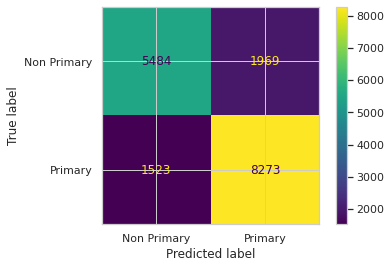

In [31]:

cm = plot_confusion_matrix(model,x_train,y_train,display_labels = ['Non Primary', 'Primary'])

In [32]:
cm.figure_.savefig('images/Confusion_Matrix_train.jpg')
plt.close()

In [33]:
run.log_image('Confusion Matrix (train)','images/Confusion_Matrix_train.jpg')

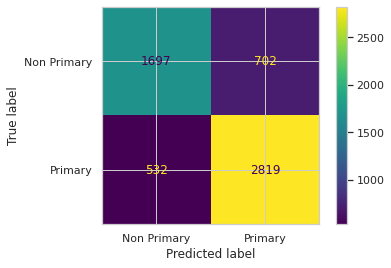

In [34]:
cm = plot_confusion_matrix(model,x_test,y_test,display_labels = ['Non Primary', 'Primary'])

In [35]:
cm.figure_.savefig('images/Confusion_Matrix_test.jpg')
plt.close()

In [36]:
run.log_image('Confusion Matrix (test)','images/Confusion_Matrix_test.jpg')

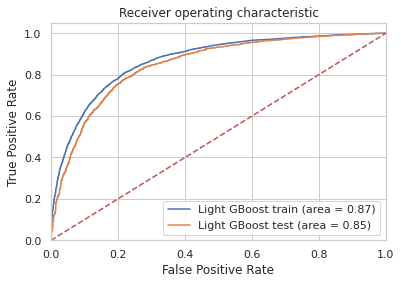

In [37]:
logit_roc_auc = roc_auc_score(y_test, model.predict(x_test))
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, model.predict_proba(x_test)[:,1])
auc_test = roc_auc = auc(fpr_test, tpr_test)

logit_roc_auc = roc_auc_score(y_train, model.predict(x_train))
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, model.predict_proba(x_train)[:,1])
auc_train = roc_auc = auc(fpr_train, tpr_train)
cm =plt.figure()
plt.plot(fpr_train, tpr_train, label='Light GBoost train (area = %0.2f)' % auc_train)
plt.plot(fpr_test, tpr_test, label='Light GBoost test (area = %0.2f)' % auc_test)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

In [38]:
cm.savefig('images/ROC.jpg')
plt.close()
run.log_image('ROC','images/ROC.jpg')

In [39]:
#explainer = shap.TreeExplainer(model, x_train)
explainer = shap.Explainer(model, x_train)
shap_values = explainer.shap_values(x_train,check_additivity=False)
x_train_array = x_train#.to_numpy() # we need to pass a dense version for the plotting functions

 98%|===================| 16934/17249 [00:43<00:00]       

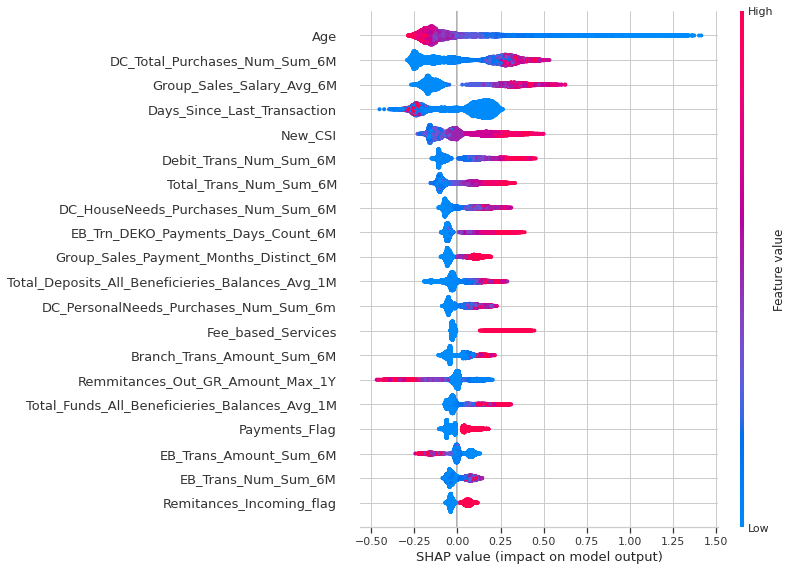

In [40]:
ss= plt.figure()
shap.summary_plot(shap_values, x_train_array,x_train.columns,max_display = 20)


In [41]:
ss.savefig('images/SHAP_Summary.jpg',bbox_inches='tight')
plt.close()
run.log_image('SHAP - Summary','images/SHAP_Summary.jpg')

In [42]:
pd.set_option('display.max_rows', None)

In [43]:
important_features = pd.DataFrame(model.feature_importances_,x_train.columns,columns =['Importance'])\
    .sort_values(by='Importance', ascending = False).head(20).index.tolist()


In [44]:
important_features

['Age',
 'Remmitances_Out_GR_Amount_Max_1Y',
 'Total_Deposits_All_Beneficieries_Balances_Avg_1M',
 'DC_Total_Purchases_Num_Sum_6M',
 'Group_Sales_Salary_Avg_6M',
 'Days_Since_Last_Transaction',
 'Branch_Trans_Amount_Sum_6M',
 'Total_Loans_Balances_OutStanding_1M',
 'EB_Trn_Login_Num_Sum_6M',
 'Total_Funds_Balance_Max_Ever',
 'Debit_Trans_Num_Sum_6M',
 'Total_Funds_All_Beneficieries_Balances_Avg_1M',
 'EB_Trans_Amount_Sum_6M',
 'DC_HouseNeeds_Purchases_Num_Sum_6M',
 'Minimum_ATM_Distance',
 'New_CSI',
 'EB_Trn_DEKO_Payments_Days_Count_6M',
 'Total_Trans_Num_Sum_6M',
 'EB_Trans_Num_Sum_6M',
 'Epistofi_Points_Amount_Sum_6M']

 99%|===================| 17074/17249 [00:43<00:00]       

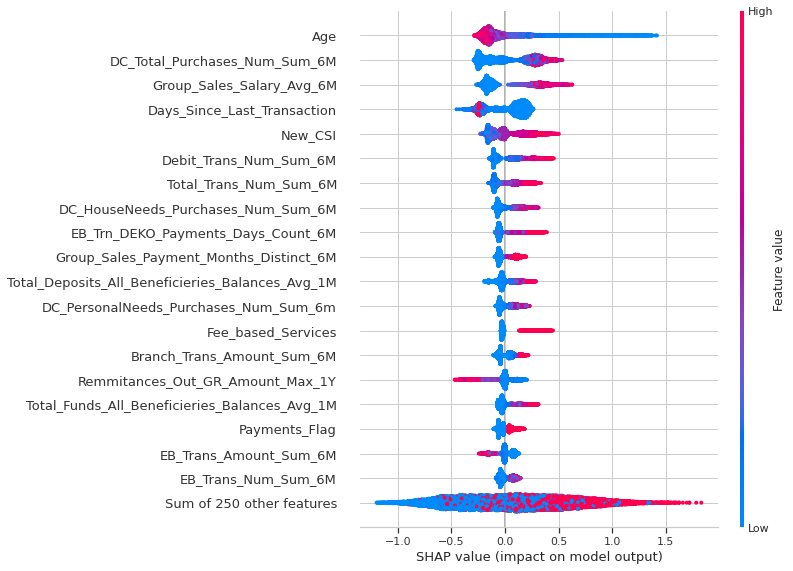

In [45]:
bs = plt.figure()
shap.plots.beeswarm(explainer(x_train),max_display = 20)

In [48]:
bs.savefig('images/SHAP_Beeswarm.jpg',bbox_inches='tight')
plt.close()
run.log_image('SHAP - Beeswarm','images/SHAP_Beeswarm.jpg')

AzureMLAggregatedException: AzureMLAggregatedException:
	Message: UserError: Resource Conflict: ArtifactId ExperimentRun/dcid.74626a4e-a016-44a2-857d-84ecf4e6c7e4/images/SHAP_Beeswarm.jpg already exists.
	InnerException None
	ErrorResponse 
{
    "error": {
        "message": "UserError: Resource Conflict: ArtifactId ExperimentRun/dcid.74626a4e-a016-44a2-857d-84ecf4e6c7e4/images/SHAP_Beeswarm.jpg already exists."
    }
}

In [50]:
run.complete()